# Computing pressure and temperature from total temperature and total pressure

In [1]:
import numpy as np

In [2]:
def gas_constant(scalars,molecular_weight):
    n=np.size(scalars)
    n_w=np.size(molecular_weight)
    universal_gas_constant=8.314
    R=0.0
    for i in range (0,n):
        R+=scalars[i]/(molecular_weight[i]/1000)
    return universal_gas_constant*R

In [3]:
def gamma(scalars, heat_capacities, molecular_weight):
    n=np.size(scalars)
    mean_heat_cp=0.0
    for i in range (0,n):
        mean_heat_cp+=heat_capacities[i]*scalars[i]
    R=gas_constant(scalars,molecular_weight)
    return mean_heat_cp/(mean_heat_cp-R)

In [4]:
def get_Pressure_Temperature_from_Pt_Ttc_Mach(Pt,Tt,Ma,scalars,heat_capacities,molecular_weight):
    gamma_value=gamma(scalars,heat_capacities,molecular_weight)
    T=Tt/(1+0.5*(gamma_value-1.0)*Ma**2)
    P=Pt/(1+0.5*gamma_value*(Ma)**2)
    return [T,P,gamma_value]

In [5]:
def get_Pt_Tt_from_P_T(P,T,Ma,scalars,heat_capacities,molecular_weight):
    gamma_value=gamma(scalars,heat_capacities,molecular_weight)
    Pt=P*(1.0+0.5*gamma_value*Ma**2)
    Tt=T*(1.0+0.5*(gamma_value-1.0)*Ma**2)
    return [Pt,Tt,gamma_value]

In [6]:
get_Pt_Tt_from_P_T(100000,300,0.1,[1.0,0.0],[2224,2224],[16.96,16.96])

[100641.37032291063, 300.4241109687319, 1.2827406458212605]

In [7]:
gas_constant([1.0,0.0],[16.96,16.96])

490.2122641509434

# Computing beta terms for low temperatures

In [8]:
#!pip install cantera

import matplotlib.pyplot as plt
import cantera as ct

In [9]:
#
# Setting the state of a mixture (Method 1)
#
# Setup themochemical state
T_mix = 300 # K
p_mix = ct.one_atm 
phi_mix = 0.7 
X_fuel = {"H2": 1.0} 
X_oxidizer = {"O2": 1.0, "N2": 3.76} 

#mechanism = "gri30.yaml"
mechanism = "h2o2.yaml"  
gas = ct.Solution(mechanism)
gas.TP = T_mix, p_mix
gas.set_equivalence_ratio(phi_mix, X_fuel, X_oxidizer, basis="mole")
Z=gas.mixture_fraction(X_fuel,X_oxidizer)
h=gas.enthalpy_mass
k=gas.thermal_conductivity
cp=gas.cp
Z_st=Z/((1-phi_mix)*Z+phi_mix)
y_H2=gas['H2'].Y[0]
y_N2=gas['N2'].Y[0]
y_O2=gas['O2'].Y[0]
progress_variable=(-7.36*y_H2)+(-2.04*y_O2)
print(gas.mass_fraction_dict())
print(Z,h,Z_st,progress_variable, cp, k)
print("Mixture state for mechanism {}".format(mechanism))
print(gas())

{'H2': 0.020137986304114414, 'N2': 0.7515544436281938, 'O2': 0.22830757006769173}
0.020137986304114418 2402.1845860029007 0.0285223875275674 -0.6139630221363732 1277.9100866538754 0.047926520948961285
Mixture state for mechanism h2o2.yaml

  ohmech:

       temperature   300 K
          pressure   1.0133e+05 Pa
           density   0.92424 kg/m^3
  mean mol. weight   22.752 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy            2402.2             54655  J
   internal energy       -1.0723e+05       -2.4397e+06  J
           entropy            8255.9        1.8784e+05  J/K
    Gibbs function       -2.4744e+06       -5.6297e+07  J
 heat capacity c_p            1277.9             29075  J/K
 heat capacity c_v            912.47             20761  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ------------

In [40]:
def beta_terms(T, phi):
    T_mix = T# K
    p_mix = ct.one_atm 
    phi_mix = phi 
    X_fuel = {"H2": 1.0} 
    X_oxidizer = {"O2": 1.0, "N2": 3.76} 
    #mechanism = "gri30.yaml"
    mechanism = "h2o2.yaml"  
    gas = ct.Solution(mechanism)
    gas.TP = T_mix, p_mix
    gas.set_equivalence_ratio(phi_mix, X_fuel, X_oxidizer, basis="mole")
    y_H2=gas['H2'].Y[0]
    y_N2=gas['N2'].Y[0]
    y_O2=gas['O2'].Y[0]
    cp=gas.cp
    X_H2= {"H2": 1.0, "O2": 0.0, "N2": 0.0}  
    gas_H2 = ct.Solution(mechanism)
    gas_H2.TPX = T_mix, p_mix, X_H2
    cp_H2=gas_H2.cp
    h_H2=gas_H2.enthalpy_mass
    X_O2= {"H2": 0.0, "O2": 1.0, "N2": 0.0}  
    gas_O2 = ct.Solution(mechanism)
    gas_O2.TPX = T_mix, p_mix, X_O2
    cp_O2=gas_O2.cp
    h_O2=gas_O2.enthalpy_mass
    X_N2= {"H2": 0.0, "O2": 0.0, "N2": 1.0}  
    gas_N2 = ct.Solution(mechanism)
    gas_N2.TPX = T_mix, p_mix, X_N2
    cp_N2=gas_N2.cp
    h_N2=gas_N2.enthalpy_mass
    lewis_numbers=[0.399,1.74]
    beta_thermal= cp-((cp_H2-cp_N2)*y_H2/lewis_numbers[0])-((cp_O2-cp_N2)*y_O2/lewis_numbers[1])
    beta_enthalpy= ((h_H2-h_N2)*y_H2/lewis_numbers[0])+((h_O2-h_N2)*y_N2/lewis_numbers[1])    
    return [beta_thermal,beta_enthalpy]

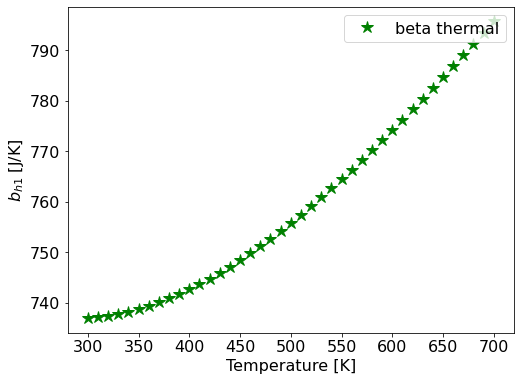

In [41]:
x=[]
y=[]
phi=0.5
for i in range(0,41):
    T=300+10*i
    x.append(T)
    y.append(beta_terms(T,phi)[0])
plt.figure(figsize=(8,6))
plt.rcParams['font.size'] = '16'
plt.plot(x, y,'g*',markersize=12, label='beta thermal')#plotting predictions
#plt.title('Adjoint design optimization') #defining titles
plt.xlabel('Temperature [K]')             #defining x-axis scaled progress variable
plt.ylabel('$b_{h1}$ [J/K]')       #y-axis output
#plt.ylim([80.9,84.75])
plt.legend(loc='upper right')   #adding a legend
#plt.savefig('/home/cristopher/Pictures/FIGURES_EPS/pressure_drop_adjoint_design.pdf', format='pdf', transparent=True, dpi=1200)
plt.show()

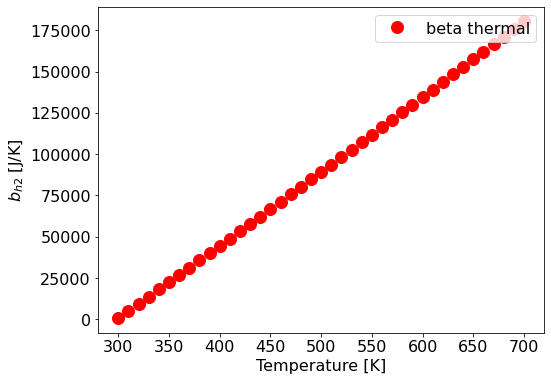

In [43]:
x1=[]
y1=[]
phi=0.5
for i in range(0,41):
    T=300+10*i
    x1.append(T)
    y1.append(beta_terms(T,phi)[1])
plt.figure(figsize=(8,6))
plt.rcParams['font.size'] = '16'
plt.plot(x1, y1,'ro',markersize=12, label='beta thermal')#plotting predictions
#plt.title('Adjoint design optimization') #defining titles
plt.xlabel('Temperature [K]')             #defining x-axis scaled progress variable
plt.ylabel('$b_{h2}$ [J/K]')       #y-axis output
#plt.ylim([80.9,84.75])
plt.legend(loc='upper right')   #adding a legend
#plt.savefig('/home/cristopher/Pictures/FIGURES_EPS/pressure_drop_adjoint_design.pdf', format='pdf', transparent=True, dpi=1200)
plt.show()